## Laboratorio 4 - Redes Neuronales
### Integrantes:
- Martín Beiro
- Julian Rodriguez

### 1. Carga de librerias

In [208]:
import torch 
import torchvision
import sklearn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

#elegimos el dispositivo a utilizar. Si hay gpyu lo usamos, sino la cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Carga de datos

El Dataset Fashion-MNIST es un conjunto de imagenes  de 10 tipos de artículos de vestimenta, con 70.000 imágenes de 28x28 en blanco y negro.
 Pytorch incluye facilidades para cargar este dataset desde su librería torchvision 

In [103]:


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root="./data", train=True,  download=True,  transform=transform, target_transform=None )

test_data = datasets.FashionMNIST(root="./data",train=False, download=True,  transform=transform)
clases=train_data.classes
print(clases)



['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Las clases presentes en el set de datos son: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'

Observemos una de las muestras del conjunto de entrenamiento y su categoría

Text(0.5, 1.0, 'Ankle boot')

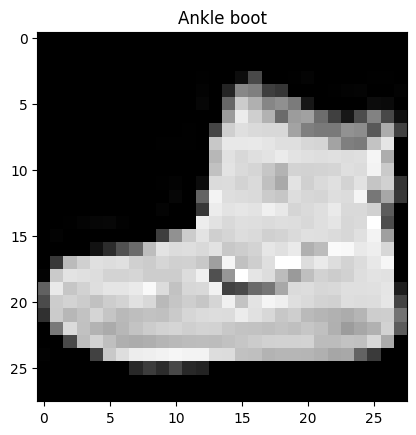

In [104]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(clases[label])

Para entrenar nos conviene crear Dataloaders, que manejan la división de los conjuntos en minibatches. Comenzaremos con un batch size típico de 32 muestras. Al modificar la cantidad de muestras en nuestro batch, modificamos la memoria que se utiliza en cada iteración, cuantas cuentas se hacen en cada epoch, y también reducimos la estocasticidad al tomar un subconjunto de muestras más grande. 


In [105]:
BATCH_SIZE = 64


train_dataloader =torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,  shuffle=True )

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False )


### 3. Red Feedforward Base

Como base, construiremos una red Feedforward sencilla, de una capa oculta, 32 unidades y activación Sigmoide. En las Siguientes secciones haremos esfuerzos por mejorar los resultados de la red base modificando hiperparámetros como cantidad de capas ocultas, funciones de activación y cantidad de unides ocultas.

Primero se crea la clase de la red como subclase de Pytorch Module, clase base para los modelos en este framework. Se debe incorporar una capa Flatten para pasar las imágenes a vectores unidimensionales , por lo que cada batch de entrada nos queda con la forma (1,28x28,tamaño del batch)

In [125]:
class FFv0(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_dimention, 10),
        torch.nn.Softmax())
    def forward(self, x):
        return self.capas(x)
    


Luego creamos el loop de entrenamiento y lo entrenamos durante 10 epocas, con un learning rate de 0.01. 

In [191]:
def train_step(model, train_dataloader, loss_fn, optimizer):
    model.train()
    train_loss= 0
    train_acc= 0
    for images, labels in train_dataloader:
        #forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss
        #backprop
        optimizer.zero_grad()
        loss.backward()
        #actualizo el modelo
        optimizer.step()
        predictions=outputs.argmax(dim=1)

        train_acc += ((predictions==labels).sum().item()/len(labels))*100
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    return train_loss, train_acc

def test_step(model, test_dataloader, loss_fn):
    model.eval()
    total=0
    correct=0
    test_loss=0
    test_acc=0
    with torch.inference_mode():
        for images, labels in test_dataloader:
            outputs = model(images)
            test_loss+=loss_fn(outputs, labels)
            predictions=outputs.argmax(dim=1)
            test_acc += ((predictions==labels).sum().item()/len(labels))*100
        # Adjust metrics and print out
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc

def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=True):
    history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])
    for epoch in range(epochs):



        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        if verbose:
            print(f"Epoca: {epoch+1} ---")

            print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
            print ("------------")
        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_acc)

        history["test_acc"].append(test_acc)
        history["test_loss"].append(test_loss.item())
    return history



In [163]:


lr=0.01
epochs=10
torch.manual_seed(55)
model_v0=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history_0_10=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 2.28866 | Train accuracy: 15.44%

Test loss: 2.27279 | Test accuracy: 28.76%

------------
Epoca: 2 ---
Train loss: 2.25013 | Train accuracy: 32.83%

Test loss: 2.22421 | Test accuracy: 33.06%

------------
Epoca: 3 ---
Train loss: 2.19653 | Train accuracy: 33.01%

Test loss: 2.17032 | Test accuracy: 33.18%

------------
Epoca: 4 ---
Train loss: 2.14718 | Train accuracy: 34.50%

Test loss: 2.12590 | Test accuracy: 35.59%

------------
Epoca: 5 ---
Train loss: 2.10591 | Train accuracy: 37.94%

Test loss: 2.08652 | Test accuracy: 41.53%

------------
Epoca: 6 ---
Train loss: 2.06585 | Train accuracy: 47.70%

Test loss: 2.04624 | Test accuracy: 50.33%

------------
Epoca: 7 ---
Train loss: 2.02774 | Train accuracy: 50.52%

Test loss: 2.01158 | Test accuracy: 51.04%

------------
Epoca: 8 ---
Train loss: 1.99749 | Train accuracy: 51.23%

Test loss: 1.98538 | Test accuracy: 51.70%

------------
Epoca: 9 ---
Train loss: 1.97398 | Train accuracy: 52.26%

Test loss: 1.

Observemos la evolución del Accuracy y la pérdida, para poder interpretar mejor los resultados

In [167]:

def plot_results(history,title,ylims):
    train_losses = history["train_loss"]
    eval_losses = history["test_loss"]
    train_accs = history["train_acc"]
    eval_accs = history["test_acc"]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Entrenamiento")
    plt.plot(range(1, len(eval_losses) + 1), eval_losses, label="Evaluación")
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida en Entrenamiento y Evaluación Arquitectura 1')
    plt.grid(True)
    plt.ylim(ylims[0])
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accs) + 1), train_accs, label="Entrenamiento")
    plt.plot(range(1, len(eval_accs) + 1), eval_accs, label="Evaluación")
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.ylim(ylims[1])
    plt.show()

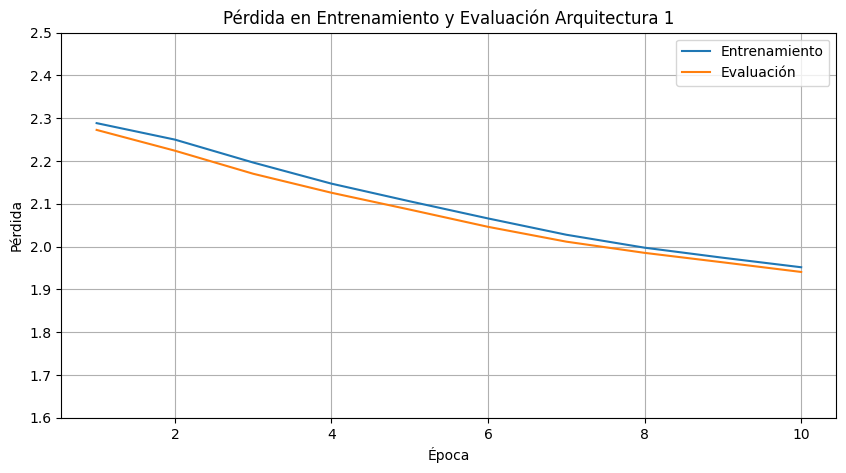

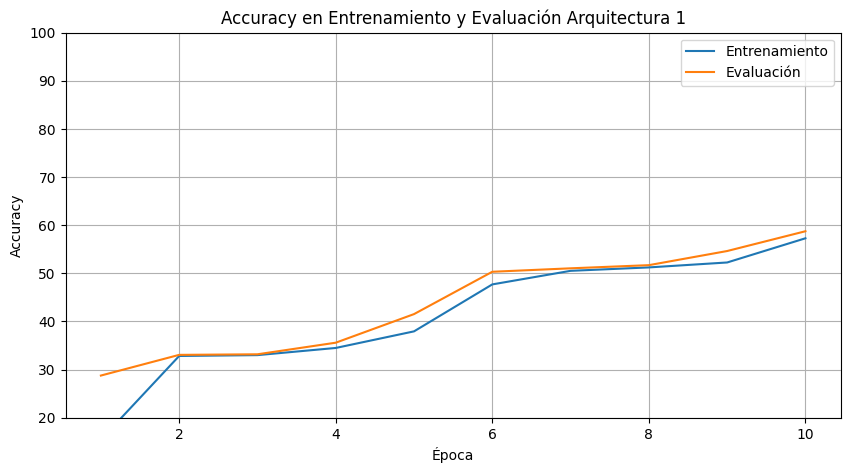

In [168]:



plot_results(history_0_10,'Accuracy en Entrenamiento y Evaluación Arquitectura 1',[[1.6,2.5],[20,100]])

La curva de las pérdidas parece correcta, aunque tal vez un poco lenta, de todas maneras habria que entrenar  por más épocas para poder sacar conclusiones. No se ve overfitting, al menos observando esta gráfica, porque van juntas las pérdidas de entrenamiento y evaluación. 
Cabe destacar que el desempeño en esta zona en ambas métricas es mejor para evaluación que para entrenamiento, pero esto es por inicialización y azar, y no es un comportamiento que se espera se mantenga al aumentar las épocas de entrenamiento.

### 4. Mejoras a la arquitectura

Con el fin de mejorar los resultados, podemos realizar pruebas modificando algunas características de la red y de su entrenamiento.  Primero realizamos pruebas aumentando el learning rate y entrenando por más épocas, para tener un poco de intuición sobre como se comporta el modelo. Limitaremos a 20 épocas el entrenamiento en esta sección, con el fin de reducir los tiempos de desarrollo en la tarea, de todas maneras, no descartamos que se puedan obtener mejoras en el desempeño entrenando más épocas y lo realizaremos al final con el modelo que seleccionemos.

In [173]:

lr=0.1
epochs=20
torch.manual_seed(55)
model_v0=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history_0_20=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoca: 1 ---
Train loss: 2.10600 | Train accuracy: 41.37%

Test loss: 1.94200 | Test accuracy: 58.81%

------------
Epoca: 2 ---
Train loss: 1.84183 | Train accuracy: 67.45%

Test loss: 1.78861 | Test accuracy: 70.62%

------------
Epoca: 3 ---
Train loss: 1.75910 | Train accuracy: 73.89%

Test loss: 1.73446 | Test accuracy: 76.72%

------------
Epoca: 4 ---
Train loss: 1.71241 | Train accuracy: 78.24%

Test loss: 1.70582 | Test accuracy: 77.96%

------------
Epoca: 5 ---
Train loss: 1.69204 | Train accuracy: 79.24%

Test loss: 1.69159 | Test accuracy: 78.99%

------------
Epoca: 6 ---
Train loss: 1.68160 | Train accuracy: 79.82%

Test loss: 1.68469 | Test accuracy: 79.47%

------------
Epoca: 7 ---
Train loss: 1.67452 | Train accuracy: 80.25%

Test loss: 1.67855 | Test accuracy: 79.78%

------------
Epoca: 8 ---
Train loss: 1.66918 | Train accuracy: 80.69%

Test loss: 1.67484 | Test accuracy: 79.88%

------------
Epoca: 9 ---
Train loss: 1.66527 | Train accuracy: 80.94%

Test loss: 1.

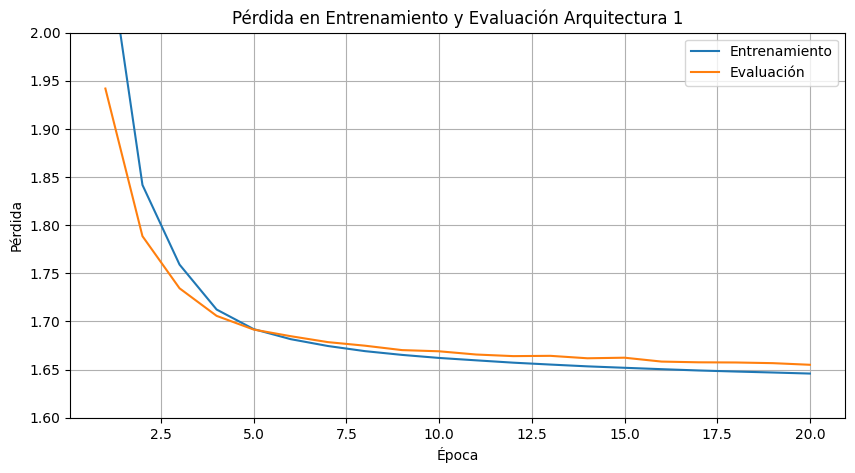

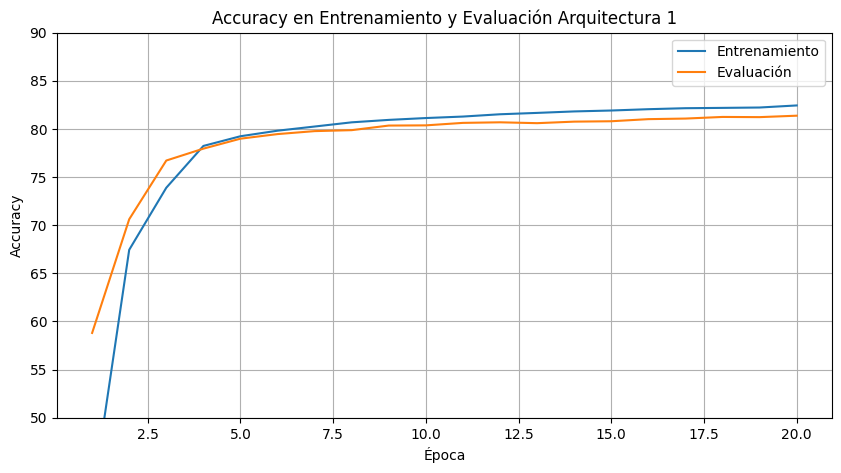

In [174]:
plot_results(history_0_20,'Accuracy en Entrenamiento y Evaluación Arquitectura 1',[[1.6,2],[50,90]])

Tomando el resultado obtenido en la época 20, con un accuracy de evaluación de 81.4%, podemos proceder a intentar superarlo. Proponemos 3 modificaciones a la arquitectura, que iremos agregando de manera incrementral

La primera, modificar la función de activación a una ReLU. 
La segunda, agregar una capa intermedia, para ver si más profundidad mejora los resultados
La tercera, aumentar la cantidad de unidades ocultas


Este analizis lo haremos con varios valores de learning rate

In [133]:
class FFv1(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, 10),
        torch.nn.Softmax())
    def forward(self, x):
        return self.capas(x)

In [192]:
class FFv2(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, 10),
        torch.nn.Softmax())
    def forward(self, x):
        return self.capas(x)  
    

    

In [135]:
lrs=[0.05,0.1,0.5]
best_model=None
best_acc=0
best_history=None
epochs=20
histories=[]
for lr in lrs:
    print(f"lr={lr}")
    loss_fn = torch.nn.CrossEntropyLoss()
    model_v1=FFv1(28*28,32).to(device)
    optimizer = torch.optim.SGD(model_v1.parameters(), lr=lr)    

    history=train_model(model_v1, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=False)
    print("Accuracy en test v1: ",history["test_acc"][-1])
    if history["test_acc"][-1]>best_acc:
        best_acc=history["test_acc"][-1]
        best_model=model_v1
        best_history=history

    histories.append(history)


    model_v2=FFv2(28*28,32).to(device)
    optimizer = torch.optim.SGD(model_v2.parameters(), lr=lr)    

    history=train_model(model_v2, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=False)
    print("Accuracy en test v2: ",history["test_acc"][-1])
    if history["test_acc"][-1]>best_acc:
        best_acc=history["test_acc"][-1]
        best_model=model_v2
        best_history=history
    histories.append(history)

    model_v3=FFv2(28*28,64).to(device)
    optimizer = torch.optim.SGD(model_v3.parameters(), lr=lr)    

    history=train_model(model_v3, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=False)
    print("Accuracy en test v3: ",history["test_acc"][-1])
    if history["test_acc"][-1]>best_acc:
        best_acc=history["test_acc"][-1]
        best_model=model_v3
        best_history=history

    histories.append(history)
    print(best_model)

lr=0.05


Accuracy en test v1:  81.24004777070064
Accuracy en test v2:  81.52866242038216
Accuracy en test v3:  80.84195859872611
FFv2(
  (capas): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
    (6): Softmax(dim=None)
  )
)
lr=0.1
Accuracy en test v1:  81.80732484076434
Accuracy en test v2:  81.55851910828025
Accuracy en test v3:  82.29498407643312
FFv2(
  (capas): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
    (6): Softmax(dim=None)
  )
)
lr=0.5
Accuracy en test v1:  81.64808917197452
Accuracy en test v2:  78.78184713375796
Accuracy en test v3:  81.5286624

Los puntajes son muy similares a los de la red base, observemos las gráficas de pérdida y accuracy

In [152]:
## grille de graficas de 3x3 con los modelos y los lr en sus perdidas 
def plot_results_grid(histories,metric,lrs,ylim=None):
    fig, axs = plt.subplots(3, 3,figsize=(15,15))
    for i in range(3):
        for j in range(3):
            history=histories[i*3+j]
            axs[i,j].plot(range(1, len(history["train_"+metric]) + 1), history["train_"+metric], label="Entrenamiento")
            axs[i,j].plot(range(1, len(history["test_"+metric]) + 1), history["test_"+metric], label="Evaluación")
            axs[i,j].set_xlabel('Época')
            axs[i,j].set_ylabel('Pérdida')
            axs[i,j].legend()
            axs[i,j].set_title(f'Pérdida en Entrenamiento y Evaluación Arquitectura {i*3+j+1} lr={lrs[i]}')
            axs[i,j].grid(True)
            axs[i,j].title.set_size(7)
            #si estan, usar y
            if ylim:
                axs[i,j].set_ylim(ylim)

    plt.show()


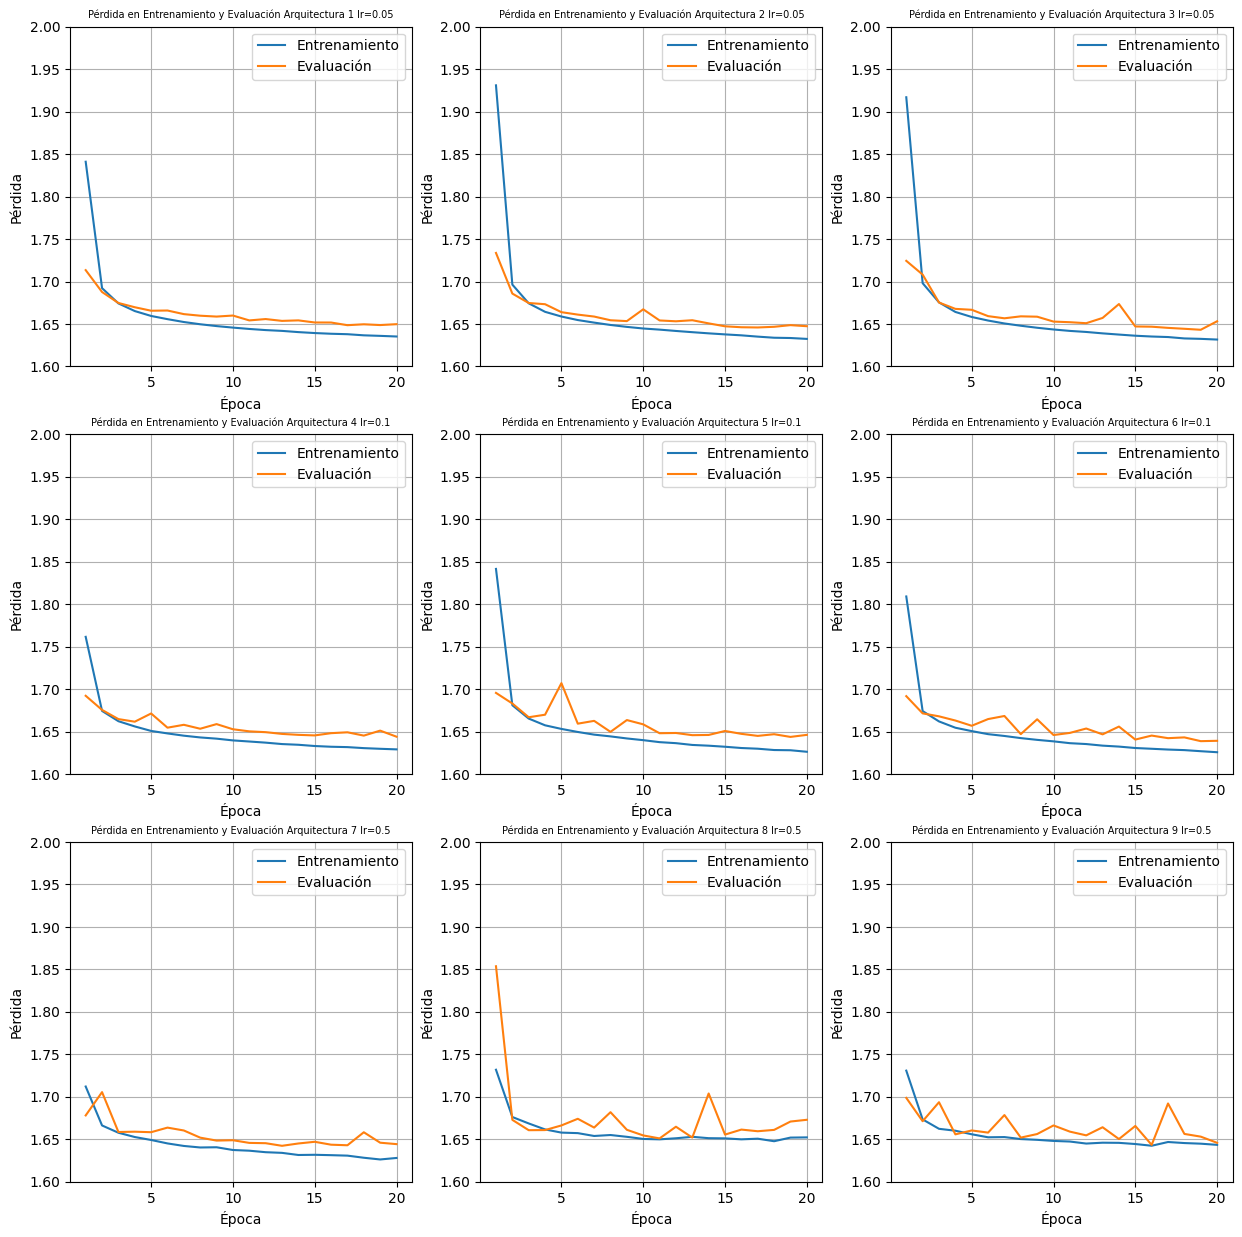

In [154]:

plot_results_grid(histories,"loss",lrs,[1.6,2])

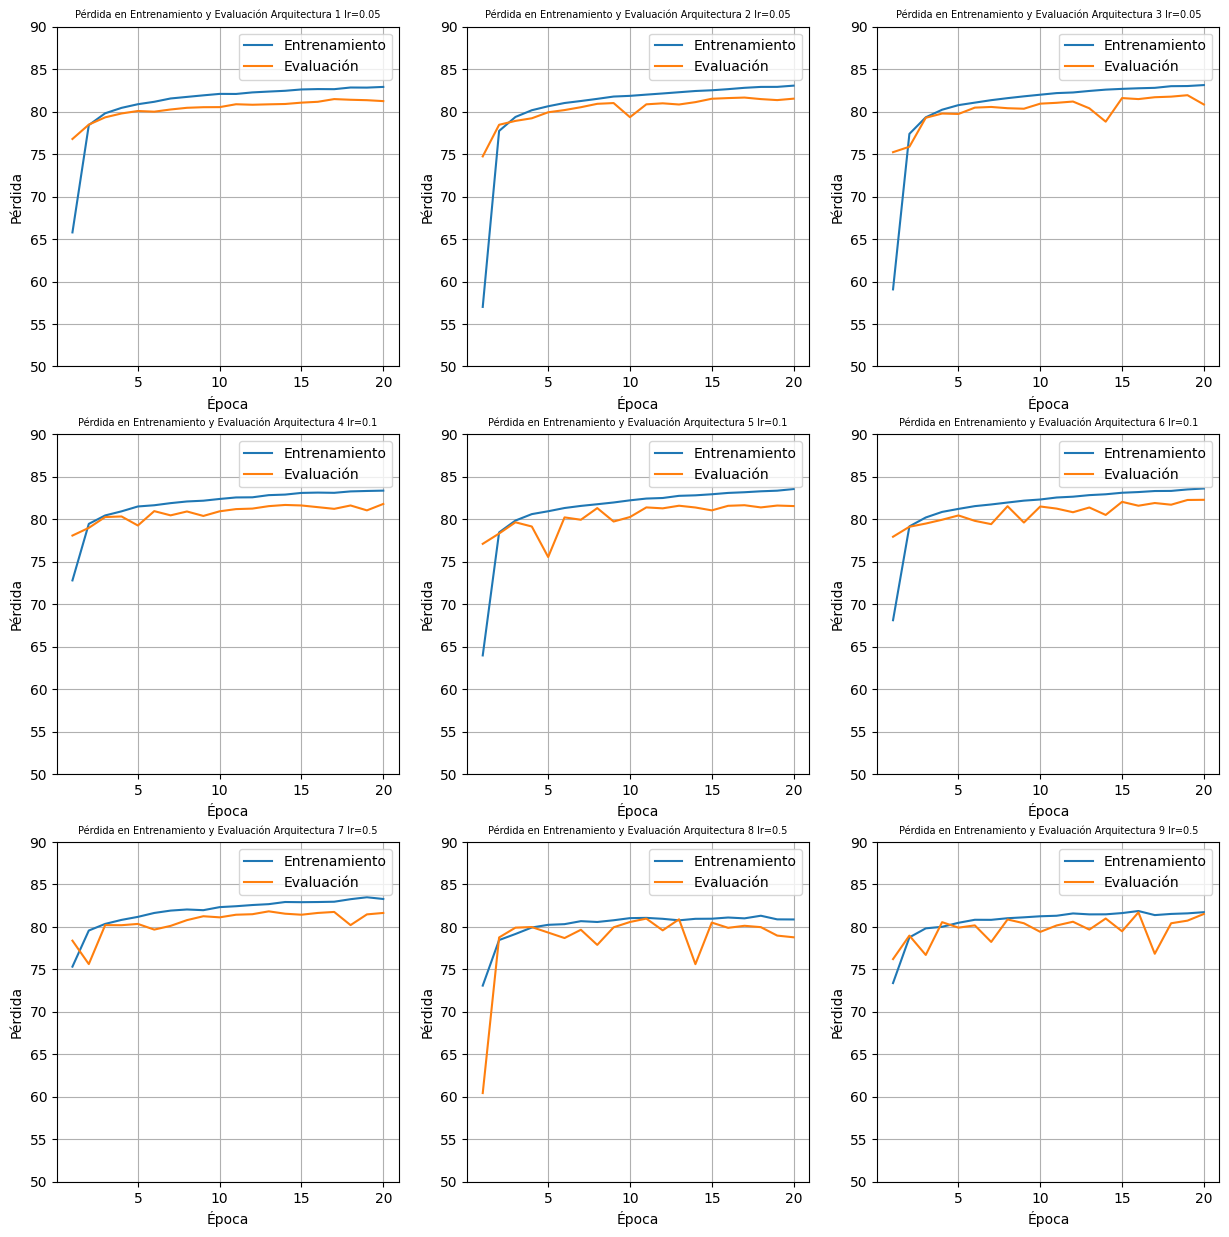

In [156]:

plot_results_grid(histories,"acc",lrs,[50,90])

Partiendo de las gráficas anteriores, encontramos que para learning rate 0.5 el comportamiento es muy inestable. Concentrando el análisis en lr 0.05 y 0.1, vemos que las curvas de entrenamiento y evaluación presentan valores similares al modelo base, aunque logramos un valor de validación de casi 1% más en el modelo tres. A su vez, las curvas se separan entre sí, lo que puede significar que tenemos margen de mejora reduciendo el sobreajuste. Para esto, en la siguiente etapa vamos a introducir regulariazación. Utilizaremos el tercer modelo para probar la regularización, con un learning rate de 0.1

### 5. Regularización

Los métodos de regularización  mediante la introducción de un factor de penalización, cambios en la estructura de la red, o modificaciones al conjunto de datos, intentan evitar que el modelo pueda ajustarse demasiado al conjunto de entrenamiento.
En este caso, utilizaremos dropout, que consiste en desactivar partes de la red en distintas iteraciones del entrenamiento para evitar que las neuronas aprendan características muy particulares de algunas muestras, y en cambio, aprendan las características más generales del conjunto. 

A su vez, aumentaremos las épocas de entrenamiento.

In [193]:
class FFv3(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.Dropout(0.25),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.25),
        torch.nn.Linear(hidden_dimention, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, 10),
        torch.nn.Softmax())
    def forward(self, x):
        return self.capas(x)  

In [200]:
lr=0.1
epochs=60
torch.manual_seed(55)
model_v3=FFv3(28*28,64).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v3.parameters(), lr=lr)

history_3_60=train_model(model_v3, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoca: 1 ---
Train loss: 1.86869 | Train accuracy: 61.57%

Test loss: 1.70270 | Test accuracy: 76.34%

------------
Epoca: 2 ---
Train loss: 1.70121 | Train accuracy: 76.82%

Test loss: 1.68440 | Test accuracy: 77.78%

------------
Epoca: 3 ---
Train loss: 1.68446 | Train accuracy: 78.12%

Test loss: 1.67060 | Test accuracy: 79.15%

------------
Epoca: 4 ---
Train loss: 1.67499 | Train accuracy: 78.97%

Test loss: 1.67054 | Test accuracy: 79.28%

------------
Epoca: 5 ---
Train loss: 1.66994 | Train accuracy: 79.35%

Test loss: 1.66731 | Test accuracy: 79.50%

------------
Epoca: 6 ---
Train loss: 1.66461 | Train accuracy: 79.85%

Test loss: 1.65834 | Test accuracy: 80.31%

------------
Epoca: 7 ---
Train loss: 1.66161 | Train accuracy: 80.17%

Test loss: 1.65434 | Test accuracy: 80.68%

------------
Epoca: 8 ---
Train loss: 1.65866 | Train accuracy: 80.40%

Test loss: 1.66121 | Test accuracy: 80.00%

------------
Epoca: 9 ---
Train loss: 1.65711 | Train accuracy: 80.57%

Test loss: 1.

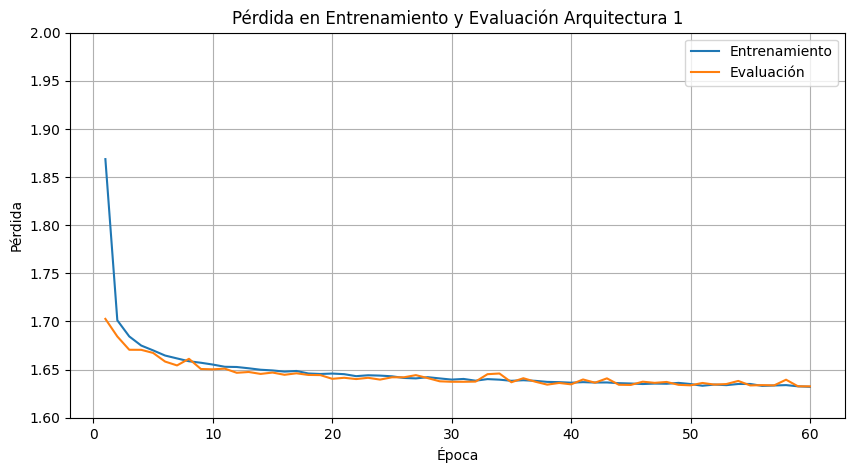

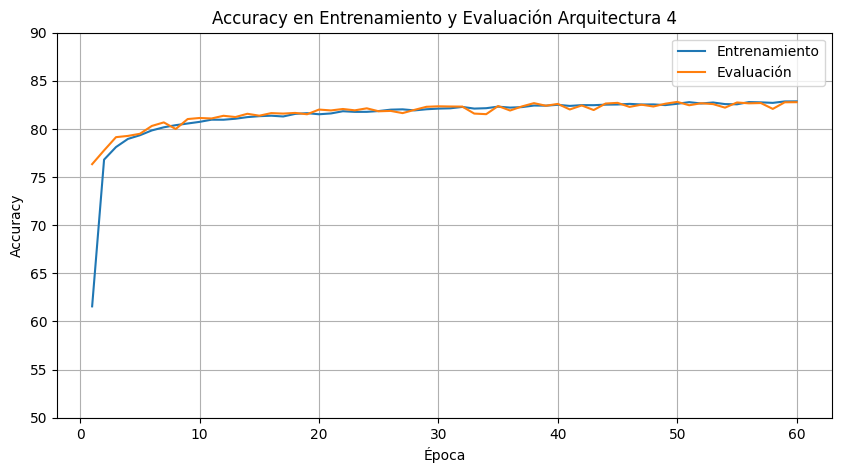

In [203]:
plot_results(history_3_60,'Accuracy en Entrenamiento y Evaluación Arquitectura 4',[[1.6,2],[50,90]])

Vemos como el efecto de la regularización es evidente, logrando mantener el error de generalización bajo, con el modelo que aprende pero no sobreajusta a los datos de entrenamiento, y llegando a un accuracy de casi 83%, y con perspectivas de seguir subiendo si entrenamos más épocas. 

In [217]:
#path="./models/model_v3.pt"
#torch.save(model_v3.state_dict(), path)
# model = FFv3(28*28,64).to(device)
# model.load_state_dict(torch.load(path))

<All keys matched successfully>

### 6. Evaluación de desempeño

In [201]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [218]:
#evaluar el model
model_v3.eval()
total=0
correct=0
test_loss=0
test_acc=0
predicted_labels=[]
true_labels=[]
with torch.inference_mode():
    for images, labels in test_dataloader:
        outputs = model_v3(images)
        test_loss+=loss_fn(outputs, labels)
        predictions=outputs.argmax(dim=1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.numpy())




# Calcular las métricas
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Construir la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 0.83
Precision: [0.69265367 0.9897541  0.67859984 0.86412512 0.6172043  0.95824847
 0.         0.92330383 0.95029821 0.94257426]
Recall: [0.924 0.966 0.853 0.884 0.861 0.941 0.    0.939 0.956 0.952]
F1: [0.79177378 0.97773279 0.75587062 0.87394958 0.71899791 0.94954591
 0.         0.93108577 0.95314058 0.94726368]


C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


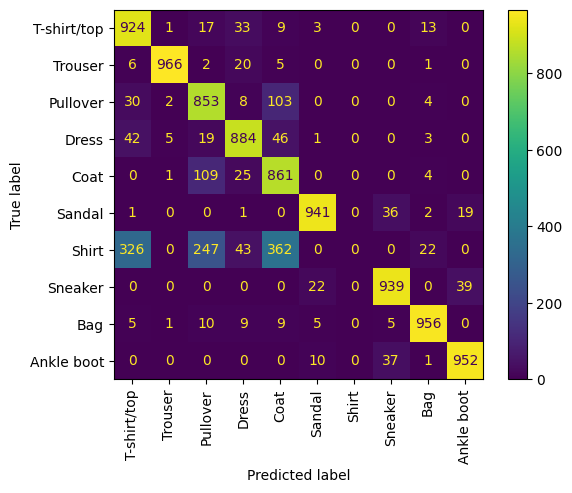

In [219]:
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, display_labels=clases, xticks_rotation=90)


!!!!!!!!!Aca hay que hacer analisis de los valores de las métricas

### 7. Estudio de errores

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Índices de las 10 muestras más difíciles: [[ 406]
 [6280]
 [3082]
 [7138]
 [8658]
 [7204]
 [2912]
 [4922]
 [ 222]
 [2048]]


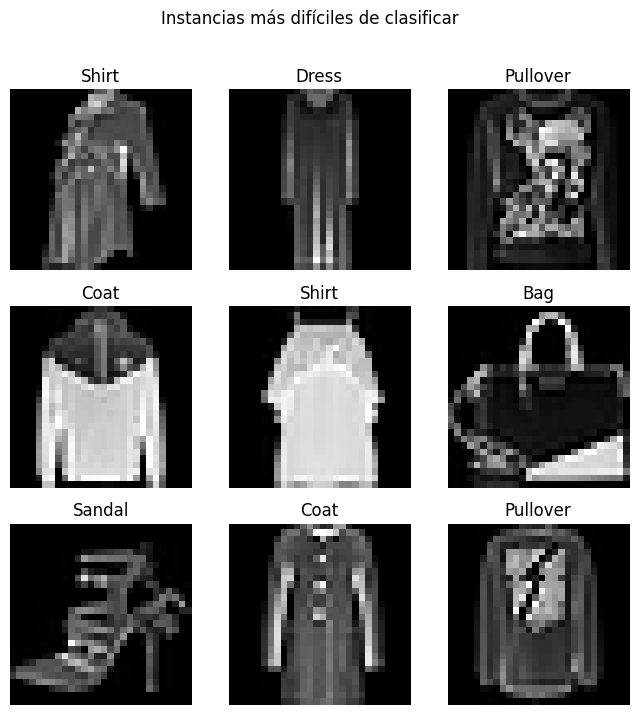

In [209]:
# Calcular la entropía para cada instancia en el conjunto de evaluación
entropies = []

for i, data in enumerate(test_data, 0):
    inputs, _ = data
    outputs = model_v3(inputs)
    softmax = torch.nn.functional.softmax(outputs, dim=1)
    log_softmax = torch.log(softmax)
    entropy = -torch.sum(softmax * log_softmax, dim=1).detach().numpy()
    entropies.append(entropy)

entropies = np.array(entropies)
difficult_samples_indices = np.argsort(entropies, axis=0)[-10:]  # Obtener las 10 muestras con las mayores entropías

# Imprimir los índices de las muestras más difíciles
print("Índices de las 10 muestras más difíciles:", difficult_samples_indices)

#%%
#Graficar los más dificiles

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = difficult_samples_indices[i-1][0]
    image, label = test_data[sample_idx]
    image = image.numpy()
    image = image / 2 + 0.5  # Desescalamos la imagen
    figure.add_subplot(rows, cols, i)
    plt.title(clases[label])
    plt.axis("off")
    plt.imshow(image[0], cmap='gray') 

figure.suptitle('Instancias más difíciles de clasificar')      
plt.show()

## capaz acá poner que categorias les dio

### 8. CNN

A modo de ejemplo, se entrena un modelo de CNN sencillo para comparar su desempeño en las mismas condiciones.
Se utilizó como ejemplo el modelo del siguiente link https://poloclub.github.io/cnn-explainer/

In [210]:
class CNN_v0(torch.nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,   kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2,  stride=2) 
        )
        self.block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [215]:
lr=0.1
epochs=10
torch.manual_seed(55)
model_CNN=CNN_v0(1,10,10).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=lr)

history_CNN_60=train_model(model_CNN, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 0.69758 | Train accuracy: 75.75%

Test loss: 0.42442 | Test accuracy: 84.09%

------------
Epoca: 2 ---
Train loss: 0.36988 | Train accuracy: 86.64%

Test loss: 0.37995 | Test accuracy: 86.27%

------------
Epoca: 3 ---
Train loss: 0.32511 | Train accuracy: 88.48%

Test loss: 0.32856 | Test accuracy: 88.05%

------------
Epoca: 4 ---
Train loss: 0.30014 | Train accuracy: 89.19%

Test loss: 0.32016 | Test accuracy: 88.76%

------------
Epoca: 5 ---
Train loss: 0.28219 | Train accuracy: 90.01%

Test loss: 0.33932 | Test accuracy: 88.54%

------------
Epoca: 6 ---
Train loss: 0.27003 | Train accuracy: 90.48%

Test loss: 0.32171 | Test accuracy: 88.18%

------------
Epoca: 7 ---
Train loss: 0.26000 | Train accuracy: 90.70%

Test loss: 0.30149 | Test accuracy: 89.32%

------------
Epoca: 8 ---
Train loss: 0.25201 | Train accuracy: 90.88%

Test loss: 0.28902 | Test accuracy: 89.91%

------------
Epoca: 9 ---
Train loss: 0.24579 | Train accuracy: 91.18%

Test loss: 0.

In [220]:
# path="./models/model_CNN.pt"
# #torch.save(model_CNN.state_dict(), path)
# model = CNN_v0(1,10,10).to(device)
# model.load_state_dict(torch.load(path))

Como puede verse, con tan solo 10 epocas se llega a un desempeño del 90%, lo que habla de la superiorridad de esta arquitectura para esta aplicación

### 9. Conclusiones

En este laboratorio vimos lo que involucra entrenar una red FeedForward, como los distintos hyperparametros afectan el desempeño y la utilidad del dropout. Se logró un desempeño razonable para la arquitectura utilizada, y se vio como utilizar una CNN aumenta la performance de manera significativa en este tipo de aplicaciones